In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

path = 'mnist-dataset/'
train_dataset = MNIST(path, transform=transform, download=True, train=True)
test_dataset = MNIST(path, transform=transform, download=True, train=False)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
device = torch.device('mps:0')

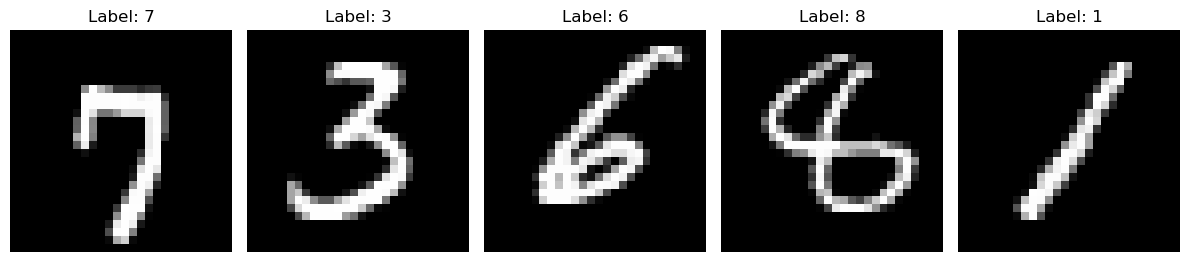

In [3]:
num_samples = 5
fig, axes = plt.subplots(1, num_samples, figsize=(12, 3))

for i, (image, label) in enumerate(train_loader):
    if i == num_samples:
        break
    axes[i].imshow(image[0][0], cmap='gray')  # Displaying the first image in each batch
    axes[i].set_title(f"Label: {label[0]}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Build VAE class
---

In [5]:
class VariationalAE(nn.Module):
    def __init__(self, input_dim: int=28*28, hidden_dim: int=400, latent_dim: int=200, device=torch.device('mps')):
        super(VariationalAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.LeakyReLU(0.2), nn.Linear(hidden_dim, latent_dim), nn.LeakyReLU(0.2)
        )
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim), nn.LeakyReLU(0.2), nn.Linear(latent_dim, hidden_dim), nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim), nn.Sigmoid()
        )
        
    def forwar(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decoder(x)
        return x_hat, mean, logvar
        
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar
    
    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(logvar).to(device)
        return mean + logvar * epsilon

In [ ]:
def loss_function(x, x_hat, mean, logvar):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return reproduction_loss + kld

def train(model: nn.Module, optimizer: torch.optim.Optimizer, epochs: int, device: torch.device,
          train_loader: DataLoader):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            print()
            x = x.view(batch_size, x).to(device)

In [ ]:



vae_model = VariationalAE(input_dim=28*28, hidden_dim=400, latent_dim=200)
optimizer = torch.optim.Adam(params=vae_model.parameters(), lr=1e-3)
